In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from pandas import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy
import matplotlib.pyplot as plt
import matplotlib
import pickle
from scipy import stats
import copy
from scipy.stats import entropy
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score

from sklearn.cluster import KMeans

# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols,gls,wls
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm
#tutorial link: https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch

In [6]:
#load data

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
train_single =torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)
train_batch =torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1000, shuffle=True)
train_full = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=60000, shuffle=True)
test_full = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10000, shuffle=True)
test_single = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [34]:
def makeSingleTrainingSet(train_single,forNumber,n=5000):
    pos=0
    neg=0
    images=[]
    targets=[]
    for image,target in train_single:
        if target.item()==forNumber and pos<n:
            images.append(image.detach().numpy().reshape((28,28)))
            targets.append([1.0])
            pos+=1
        if target.item()!=forNumber and neg<n:
            images.append(image.detach().numpy().reshape((28,28)))
            neg+=1
            targets.append([-1.0])
    return numpy.array(images),numpy.array(targets)

images,targets=makeSingleTrainingSet(train_single,0)

In [7]:
#train individual networks

In [5]:
class Net(nn.Module):
    def __init__(self, input_dim=28*28,hidden_dim=100,output_dim=10):
        super(Net, self).__init__()
        self.hiddenLayer=nn.Linear(input_dim,hidden_dim)
        self.outputLayer=nn.Linear(hidden_dim,output_dim)
    
    def forward(self, x):
        out=x.view(-1,28*28)
        self.hidden=[]
        out=torch.tanh(self.hiddenLayer(out))
        self.hidden.append(copy.deepcopy(out.detach().numpy()))
        #out=torch.sigmoid(self.outputLayer(out))
        out=torch.tanh(self.outputLayer(out))
        return out#F.log_softmax(out, dim=1)#out
                
        
    
#myANN=Net(28*28,100,10)
#myANN
model=Net(28*28,5,1)
model(torch.Tensor(numpy.random.random((10,28*28))))

tensor([[-0.2772],
        [-0.2061],
        [-0.3945],
        [-0.2181],
        [-0.1770],
        [-0.2304],
        [-0.3380],
        [-0.1932],
        [-0.2409],
        [-0.2715]], grad_fn=<TanhBackward0>)

In [ ]:
# you need to run this code to recreate the necessary data for late analysis

In [86]:
hiddenWidth=2
for targetNumber in range(10):
    images,targets=makeSingleTrainingSet(train_single,targetNumber)
    imagesT,targetsT=makeSingleTrainingSet(test_single,targetNumber)
    model=Net(28*28,hiddenWidth,1)
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    error = nn.MSELoss()
    acc=0.0
    Wtrain=[]
    Wtest=[]
    while acc<0.98:
        order=numpy.random.choice(range(10000),(10000),replace=False)
        correct=0
        count=0
        optimizer.zero_grad()
        output = model(torch.Tensor(images[order]))
        loss = error(output, torch.Tensor(targets[order]))
        loss.backward()
        optimizer.step()
        o=1.0*(output.detach().numpy().flatten()>0.0) 
        t=1.0*(targets[order].flatten()>0.0)
        acc=(1.0*(o==t)).mean()
        Wtrain.append(acc)

        output = model(torch.Tensor(imagesT))
        o=1.0*(output.detach().numpy().flatten()>0.0) 
        t=1.0*(targetsT.flatten()>0.0)
        accT=(1.0*(o==t)).mean()

        Wtest.append(accT)
    print(targetNumber,len(Wtrain),Wtrain[-1],Wtest[-1])
    #torch.save(model.state_dict(), "subModel/model_{0}_tanh_{1}.model".format(hiddenWidth,targetNumber))
    pickle.dump(Wtrain,open("subModel/Wtrain_model_{0}_tanh_{1}.model".format(hiddenWidth,targetNumber),"wb"))
    pickle.dump(Wtest,open("subModel/Wtest_model_{0}_tanh_{1}.model".format(hiddenWidth,targetNumber),"wb"))


0 180 0.98 0.9804347826086957
1 128 0.98 0.9841890790546047
2 2545 0.98 0.9670092838196287
3 5538 0.98 0.9362728785357737
4 1176 0.98 0.9660648612504179
5 1700 0.98 0.9526476578411406
6 683 0.98 0.9721383014434374
7 1118 0.98 0.9716323822163239
8 2832 0.98 0.9278540341479745
9 2312 0.98 0.9549009818605425


In [9]:
#compose full network from that

In [35]:
class ComposedNet(nn.Module):
    def __init__(self, input_dim=28*28,hidden_dim=50,output_dim=10):
        super(ComposedNet, self).__init__()
        self.hiddenLayer=nn.Linear(input_dim,hidden_dim)
        self.outputLayer=nn.Linear(hidden_dim,output_dim)
        self.output_dim=output_dim
        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        
    def forward(self, x):
        out=x.view(-1,28*28)
        self.hidden=[]
        out=torch.tanh(self.hiddenLayer(out))
        self.hidden.append(copy.deepcopy(out.detach().numpy()))
        #out=torch.sigmoid(self.outputLayer(out))
        out=torch.tanh(self.outputLayer(out))
        return out#F.log_softmax(out, dim=1)#out
    
    def forwardWithNodeNoise(self, x,nodes,theVar=0.1):
        out=x.view(-1,28*28)
        self.hidden=[]
        out=torch.tanh(self.hiddenLayer(out))
        self.hidden.append(copy.deepcopy(out.detach().numpy()))
        #out=torch.sigmoid(self.outputLayer(out))
        l=out.shape[0]
        out=torch.transpose(out,0,1).detach().numpy()
        for node in nodes:
            out[node]+=numpy.random.uniform(0.0,theVar,(l))
        out=torch.transpose(torch.tensor(out),0,1)
        out=torch.tanh(self.outputLayer(out))
        return out#F.log_softmax(out, dim=1)#out
    
    def stepBlock(self,x,nodes,block):
        out=x.view(-1,28*28)
        out=torch.tanh(self.hiddenLayer(out))
        out=torch.transpose(out,0,1)
        for node in nodes:
            out[node]=torch.Tensor(block.transpose()[node])
        out=torch.transpose(out,0,1)
        out=torch.tanh(self.outputLayer(out))
        return out
    
    def BackUpWeights(self):
        self.BUweights=copy.deepcopy(self.state_dict())
        
    def unblock(self,nodes):
        weights=self.state_dict()
        #print(weights["outputLayer.weight"].shape)
        for node in nodes:
            weights["hiddenLayer.weight"][node]=self.BUweights["hiddenLayer.weight"][node]
            weights["hiddenLayer.bias"][node]=self.BUweights["hiddenLayer.bias"][node]
            for i in range(self.output_dim):
                weights["outputLayer.weight"][i][node]=self.BUweights["outputLayer.weight"][i][node]
        self.load_state_dict(weights)
        
    def block(self,nodes):
        weights=self.state_dict()
        #print(weights["outputLayer.weight"].shape)
        for node in nodes:
            weights["hiddenLayer.weight"][node]=torch.Tensor(numpy.zeros((weights["hiddenLayer.weight"].shape[1])))
            weights["hiddenLayer.bias"][node]=0.0
            for i in range(self.output_dim):
                weights["outputLayer.weight"][i][node]=0.0
        self.load_state_dict(weights)
        
    def noiseLastLayerNodes(self,nodes):
        weights=self.state_dict()
        #print(weights["outputLayer.weight"].shape)
        for node in nodes:
            for i in range(self.output_dim):
                weights["outputLayer.weight"][i][node]=numpy.random.normal(0.0,0.1)
        self.load_state_dict(weights)
        
    def toneDownGradients(self,dampening):
        self.hiddenLayer.weight.grad=torch.Tensor((self.hiddenLayer.weight.grad.detach().numpy().transpose()*dampening).transpose())
        self.hiddenLayer.bias.grad*=torch.Tensor(dampening)
        for i in range(self.output_dim):
            self.outputLayer.weight.grad[i]*=torch.Tensor(dampening)

model=ComposedNet(hidden_dim=20)
model.BackUpWeights()
print(model.BUweights.keys())


odict_keys(['hiddenLayer.weight', 'hiddenLayer.bias', 'outputLayer.weight', 'outputLayer.bias'])


In [13]:
#this code composes a full network from the 10 subsets

In [6]:
hiddenWidth=2
masterModel=ComposedNet(hidden_dim=hiddenWidth*10)
masterWeights=masterModel.state_dict()
for k in masterWeights.keys():
    #masterWeights[k]=torch.Tensor(numpy.zeros(masterWeights[k].shape))
    masterWeights[k]=torch.Tensor(numpy.random.normal(0.0,0.001,masterWeights[k].shape))
for t in range(10):
    subModel=Net(28*28,hiddenWidth,1)
    subModel.load_state_dict(torch.load("subModel/model_{0}_tanh_{1}.model".format(hiddenWidth,t)))
    subWeights=subModel.state_dict()
    for x in range(hiddenWidth):
        for y in range(784):
            masterWeights['hiddenLayer.weight'][t*hiddenWidth+x][y]=subWeights['hiddenLayer.weight'][x][y]
        masterWeights['hiddenLayer.bias'][t*hiddenWidth+x]=subWeights['hiddenLayer.bias'][x]
    for x in range(hiddenWidth):
        masterWeights['outputLayer.weight'][t][(t*hiddenWidth)+x]=subWeights['outputLayer.weight'][0][x]
    masterWeights['outputLayer.bias'][t]=subWeights['outputLayer.bias'][0]
masterModel.load_state_dict(masterWeights)
torch.save(masterModel,"composeMasterModel.model")

NameError: name 'Net' is not defined

In [15]:
#test for all 10 subsets

0 (5923, 1, 28, 28)
1 (6742, 1, 28, 28)
2 (5958, 1, 28, 28)
3 (6131, 1, 28, 28)
4 (5842, 1, 28, 28)
5 (5421, 1, 28, 28)
6 (5918, 1, 28, 28)
7 (6265, 1, 28, 28)
8 (5851, 1, 28, 28)
9 (5949, 1, 28, 28)
0 (980, 1, 28, 28)
1 (1135, 1, 28, 28)
2 (1032, 1, 28, 28)
3 (1010, 1, 28, 28)
4 (982, 1, 28, 28)
5 (892, 1, 28, 28)
6 (958, 1, 28, 28)
7 (1028, 1, 28, 28)
8 (974, 1, 28, 28)
9 (1009, 1, 28, 28)


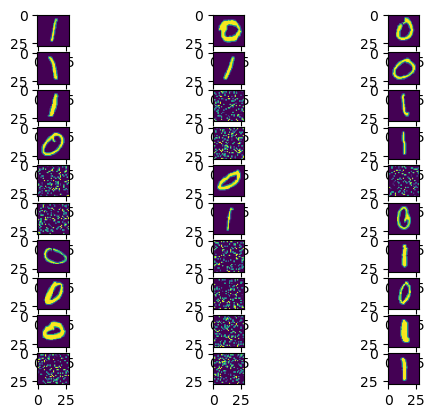

In [36]:
def makeCFtrainSet(imageNumber,numbers,n,randomizeOrder=True,scrambleNumbers=[]):
    for i,number in enumerate(numbers):
        T=numpy.zeros((10,n[i]))-1.0
        T[number]=numpy.ones((n[i]))
        T=T.transpose()
        I=numpy.array([number]*n[i])
        which=numpy.random.choice(range(len(imageNumber[number])),(n[i]),replace=False)
        if number==numbers[0]:
            images=numpy.array(imageNumber[number][which])
            if number in scrambleNumbers:
                originalShape=images.shape
                images=images.flatten()
                numpy.random.shuffle(images)
                images=images.reshape(originalShape)
            targets=T
            ids=I
        else:
            toAdd=imageNumber[number][which]
            if number in scrambleNumbers:
                originalShape=toAdd.shape
                toAdd=toAdd.flatten()
                numpy.random.shuffle(toAdd)
                toAdd=toAdd.reshape(originalShape)
            images=numpy.concatenate((images,toAdd))
            targets=numpy.concatenate((targets,T))
            ids=numpy.concatenate((ids,I))
    if randomizeOrder:
        order=numpy.random.choice(range(images.shape[0]),(images.shape[0]),replace=False)
        images=images[order]
        targets=targets[order]
        ids=ids[order]
    return images,targets,ids

imageNumberDataSet=[]
for i in range(10):
    imageNumberDataSet.append([])
for images,targets in train_full:
    for i in range(60000):
        imageNumberDataSet[targets[i].item()].append(images[i].detach().numpy())
for i in range(10):
    imageNumberDataSet[i]=numpy.array(imageNumberDataSet[i])
    print(i,imageNumberDataSet[i].shape)

testImageNumberDataSet=[]
for i in range(10):
    testImageNumberDataSet.append([])
for images,targets in test_full:
    for i in range(10000):
        testImageNumberDataSet[targets[i].item()].append(images[i].detach().numpy())
for i in range(10):
    testImageNumberDataSet[i]=numpy.array(testImageNumberDataSet[i])
    print(i,testImageNumberDataSet[i].shape)
    
images,targets,ids=makeCFtrainSet(imageNumberDataSet,[0,1,2],[10,10,10],scrambleNumbers=[2])
for i in range(30):
    subplot(10,3,i+1)
    imshow(images[i][0])

In [37]:
def testOnAllTen(model,imageNumberDataSet,howMany=1000):
    images,targets,ids=makeCFtrainSet(imageNumberDataSet,[0,1,2,3,4,5,6,7,8,9],[howMany]*10,randomizeOrder=False)
    numberIDsOther=[[],[],[],[],[],[],[],[],[],[]]
    numberIDsThis=[[],[],[],[],[],[],[],[],[],[]]
    for i in range(10):
        for j in range(10):
            I=list(range(j*howMany,(j+1)*howMany))
            if j!=i:
                numberIDsOther[i]+=I
            else:
                numberIDsThis[i]+=I
    numberIDsThis=numpy.array(numberIDsThis)
    numberIDsOther=numpy.array(numberIDsOther)
    output=2.0*(model(torch.tensor(images)).detach().numpy().transpose()>0.0)-1.0
    C=list()
    targets=targets.transpose()
    for n in range(10):
        otherID=numpy.random.choice(numberIDsOther[n],(howMany),replace=False)
        TP=(1.0*(targets[n][numberIDsThis[n]]==output[n][numberIDsThis[n]])).sum()
        TN=(1.0*(targets[n][otherID]==output[n][otherID])).sum()
        C.append((TP+TN)/(howMany+howMany))
        #print(ids.shape)
    return C
w=testOnAllTen(model,imageNumberDataSet,howMany=5000)
print(w)

[0.3581, 0.5, 0.474, 0.5407, 0.4926, 0.5014, 0.5, 0.4496, 0.4858, 0.5625]


In [19]:
#train a full network (20 nodes hidden)
#this code needs to be rerun to create the necessary data for analysis

1 0.5006999999999999
2 0.6731499999999999
3 0.7752
4 0.8491500000000001
5 0.8853500000000001
6 0.9009499999999999
7 0.9108500000000002
8 0.91815
9 0.9220499999999999
10 0.9277000000000001
11 0.9314000000000002
12 0.9356
13 0.9358000000000001
14 0.9378500000000001
15 0.9387000000000001
16 0.9385999999999999
17 0.9417000000000002
18 0.9468499999999999
19 0.9446
20 0.9441499999999999
21 0.9454
22 0.9456
23 0.9506
24 0.9491499999999998
25 0.9494
26 0.9549
27 0.9523999999999999
28 0.9539500000000001
29 0.9528000000000001
30 0.9557499999999999
31 0.95595
32 0.9558500000000001
33 0.9556999999999999
34 0.959
35 0.9587
36 0.95685
37 0.9545999999999999
38 0.9589000000000001
39 0.9590500000000001
40 0.95975
41 0.9581999999999999
42 0.95875
43 0.96175


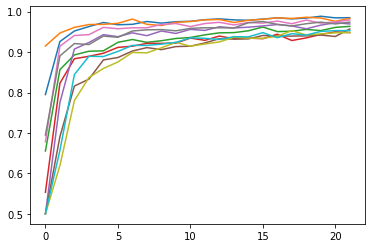

In [37]:
model=ComposedNet(28*28,20,10)
optimizer = optim.Adam(model.parameters(),lr=0.001)
error = nn.MSELoss()
acc=0.0
Wtrain=[]
Wtest=[]
count=0
while acc<0.96:
    for image,target in train_batch:
        optimizer.zero_grad()
        targets=numpy.zeros((1000,10))-1.0
        for i,t in enumerate(target):
            targets[i][t]=1.0
        output = model(torch.Tensor(image))
        loss = error(output, torch.Tensor(targets))
        loss.backward()
        optimizer.step()
    Wtrain.append(testOnAllTen(model,imageNumberDataSet))
    acc=mean(Wtrain[-1])
    Wtest.append(testOnAllTen(model,testImageNumberDataSet,howMany=800))
    count+=1
    print(count,acc)
plot(W)

In [83]:
model.load_state_dict(torch.load("paper/composedModel.model"))
model

ComposedNet(
  (hiddenLayer): Linear(in_features=784, out_features=20, bias=True)
  (outputLayer): Linear(in_features=20, out_features=10, bias=True)
)

In [ ]:
#be mindfull about loading and saving models! Don't accidentally override models you wanted to analyse!

In [41]:
torch.save(model.state_dict(), "paper/fullModel.model")
pickle.dump(Wtest,open("paper/fullModel_Wtest.p","wb"))
pickle.dump(Wtrain,open("paper/fullModel_Wtrain.p","wb"))

43


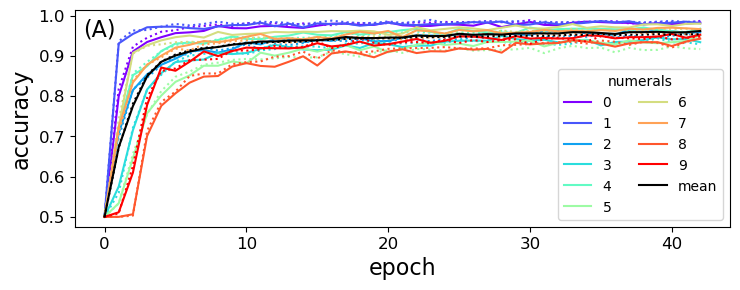

In [5]:
Wtest=pickle.load(open("paper/fullModel_Wtest.p","rb"))
Wtrain=pickle.load(open("paper/fullModel_Wtrain.p","rb"))
cmap = matplotlib.cm.get_cmap('rainbow')
figure(figsize=[7.5,3])
for i in range(10):
    plot(transpose(Wtrain)[i],'-',color=cmap(linspace(0,1,10)[i]),label=str(i))
    plot(transpose(Wtest)[i],':',color=cmap(linspace(0,1,10)[i]))
plot(numpy.array(Wtrain).mean(1),'k-',label='mean')
plot(numpy.array(Wtest).mean(1),'k:')
xlabel("epoch",fontsize=16)
ylabel("accuracy",fontsize=16)
xticks(fontsize=12)
yticks(fontsize=12)
legend(title="numerals",ncol=2,fontsize=10)
text(-1.5,0.95,"(A)",fontsize=16)
tight_layout()
savefig("fullTraining.pdf")
print(len(Wtest))

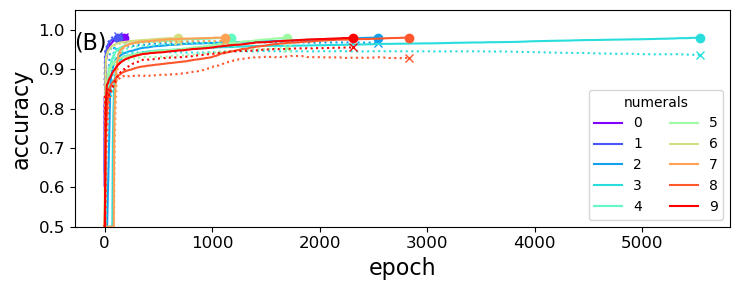

In [11]:
hiddenWidth=2
cmap = matplotlib.cm.get_cmap('rainbow')
figure(figsize=[7.5,3])
for i in range(10):
    Wtrain=pickle.load(open("subModel/Wtrain_model_{0}_tanh_{1}.model".format(hiddenWidth,i),"rb"))
    plot(Wtrain,"-",label=str(i),color=cmap(linspace(0,1,10)[i]))
    plot(len(Wtrain),Wtrain[-1],"o",color=cmap(linspace(0,1,10)[i]))
    Wtest=pickle.load(open("subModel/Wtest_model_{0}_tanh_{1}.model".format(hiddenWidth,i),"rb"))
    plot(Wtest,":",color=cmap(linspace(0,1,10)[i]))
    plot(len(Wtrain),Wtest[-1],"x",color=cmap(linspace(0,1,10)[i]))
xlabel("epoch",fontsize=16)
ylabel("accuracy",fontsize=16)
xticks(fontsize=12)
yticks(fontsize=12)
legend(title="numerals",ncol=2,fontsize=10)
ylim(0.5,1.05)
text(-280,0.95,"(B)",fontsize=16)
tight_layout()
savefig("composedTraining.pdf")

In [44]:
hiddenWidth=2
masterModel=ComposedNet(hidden_dim=hiddenWidth*10)
masterWeights=masterModel.state_dict()
for k in masterWeights.keys():
    masterWeights[k]=torch.Tensor(numpy.zeros(masterWeights[k].shape))
    #masterWeights[k]=torch.Tensor(numpy.random.normal(0.0,0.000001,masterWeights[k].shape))
Wtrain=[]
Wtest=[]
masterModel.load_state_dict(masterWeights)
Wtrain.append(testOnAllTen(masterModel,imageNumberDataSet,howMany=4000))
Wtest.append(testOnAllTen(masterModel,testImageNumberDataSet,howMany=800))
torch.save(masterModel.state_dict(), "recordFigures/model_20hs_composition_{0}_{1}.model".format(-1,0))

for t in range(10):
    subModel=Net(28*28,hiddenWidth,1)
    subModel.load_state_dict(torch.load("subModel/model_{0}_tanh_{1}.model".format(hiddenWidth,t)))
    subWeights=subModel.state_dict()
    for x in range(hiddenWidth):
        for y in range(784):
            masterWeights['hiddenLayer.weight'][t*hiddenWidth+x][y]=subWeights['hiddenLayer.weight'][x][y]
        masterWeights['hiddenLayer.bias'][t*hiddenWidth+x]=subWeights['hiddenLayer.bias'][x]
    for x in range(hiddenWidth):
        masterWeights['outputLayer.weight'][t][(t*hiddenWidth)+x]=subWeights['outputLayer.weight'][0][x]
    masterWeights['outputLayer.bias'][t]=subWeights['outputLayer.bias'][0]
    masterModel.load_state_dict(masterWeights)
    Wtrain.append(testOnAllTen(masterModel,imageNumberDataSet,howMany=5000))
    Wtest.append(testOnAllTen(masterModel,testImageNumberDataSet,howMany=800))
    torch.save(masterModel.state_dict(), "recordFigures/model_20hs_composition_{0}_{1}.model".format(t,0))

In [45]:
torch.save(masterModel.state_dict(), "paper/composedModel.model")
pickle.dump(Wtest,open("paper/composedModel_Wtest.p","wb"))
pickle.dump(Wtrain,open("paper/composedModel_Wtrain.p","wb"))

In [1]:
#figure does not show up in the paper but is a nice visulization of adding parts to the network goes hand in hand with functional gain

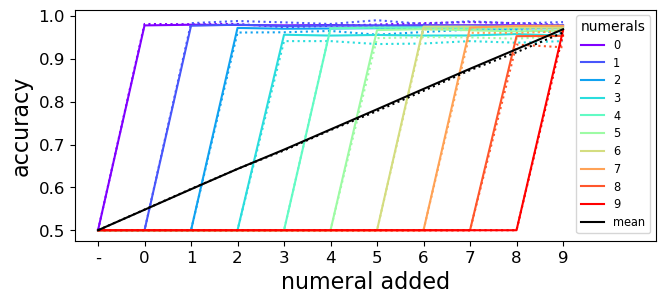

In [81]:
figure(figsize=[7.5,3])
Wtest=pickle.load(open("paper/composedModel_Wtest.p","rb"))
Wtrain=pickle.load(open("paper/composedModel_Wtrain.p","rb"))
cmap = cm.get_cmap('rainbow')
for i in range(10):
    plot(transpose(Wtrain)[i],'-',color=cmap(linspace(0,1,10)[i]),label=str(i))
    plot(transpose(Wtest)[i],':',color=cmap(linspace(0,1,10)[i]))
plot(numpy.array(Wtrain).mean(1),'k-',label="mean")
plot(numpy.array(Wtest).mean(1),'k:')
xlim(-0.5,12)
xticks([0,1,2,3,4,5,6,7,8,9,10],["-",'0','1','2','3','4','5','6','7','8','9'],fontsize=12)
yticks(fontsize=12)
legend(title="numerals",ncol=1,fontsize=8.2)
xlabel("numeral added",fontsize=16)
ylabel("accuracy",fontsize=16)
savefig("composedTesting.pdf")

In [2]:
# a lot of code comes now to make the greedy algorithm work

In [9]:
#from scipy.stats import entropy
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    #print(I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes=list(range(width))
    cols=[]
    colh=[]
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh

def getOutTaH(model,dataSet):
    dataSet=train_full
    for batch_idx, (d, t) in enumerate(dataSet):
        o = model(d)#+torch.Tensor(numpy.random.uniform(0.0,0.1,d.shape)))
        h=model.hidden
        data=d
        target=t.detach().numpy()
        output=o.detach().numpy()
        hidden=numpy.array(model.hidden[0])

        A=hidden.transpose()
        
    B=numpy.zeros(A.shape)
    clusterNr=2
    for i in range(B.shape[0]):
        a=A[i].reshape(-1,1)
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(A[i]>numpy.median(A[i]))


    H=numpy.zeros((target.shape))
    for i in range(20):
        H+=B[i]*(2**i)
    H=H.astype((int))
    return output,target,H

def shrinkingDecompositionInformation(model,width,dataSet,numbers=[0,1,2,3,4,5,6,7,8,9]):
    output,target,H=getOutTaH(model,dataSet)
    collectorSet=dict()
    collectorH=dict()
    for number in numbers:
        I=(1.0*(target==number)).astype(int)
        O=(1.0*(output.argmax(axis=1)==number)).astype(int)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH

S,H=shrinkingDecompositionInformation(model,20,test_full)

In [60]:
#testing the output from above
for i in range(20):
    print(S[0][i],H[0][i])

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 0.4207621299617088
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19] 0.4203201547676825
[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19] 0.41947763921058545
[0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19] 0.41745327452388103
[3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19] 0.41443416678258593
[3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19] 0.4012348069006535
[3, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 19] 0.389542461258765
[3, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 19] 0.37435056151973534
[3, 5, 6, 7, 8, 9, 14, 15, 16, 17, 19] 0.353779024320211
[3, 5, 6, 8, 9, 14, 15, 16, 17, 19] 0.33449961683249096
[3, 5, 6, 8, 9, 14, 15, 16, 19] 0.30351905660889944
[3, 5, 6, 8, 14, 15, 16, 19] 0.26043932784501855
[3, 6, 8, 14, 15, 16, 19] 0.23037888203747325
[3, 6, 8, 14, 15, 16] 0.16736279490648265
[3, 6, 8, 14, 16] 0.15643982405639356
[3, 6, 8, 16] 0.07337311651687095
[6, 8, 16] 0.0448264903168

In [ ]:
#generating the KO data with a single core takes forever (>24h), so we did this using MSU's HPCC, 1.2 GB file upon request to ahz@du.se

In [13]:
def aggregateData(filename):
    dataS=pickle.load(open("HPCCdata/shrinkingDec_{0}.p".format(filename),"rb"))
    dataKO=numpy.zeros((2**20,10))
    for i in range(256):
        data=pickle.load(open("HPCCdata/KO_{0}_{1}.p".format(i,filename),"rb"))
        for k in data.keys():
            dataKO[k]=numpy.array(data[k])
    dataI=numpy.zeros((10,2**20))
    for i in range(10):
        dataAB=pickle.load(open("HPCCdata/subDec_{0}_{1}.p".format(i,filename),"rb"))
        dataI[i]=dataAB[i]
    dataR=numpy.zeros((10,2**20))
    for i in range(10):
        data=pickle.load(open("HPCCdata/rDec_{0}_{1}.p".format(i,filename),"rb"))
        dataR[i]=numpy.array(data[i])
    return dataS,dataKO.transpose(),dataI,dataR

dataS,dataKO,dataI,dataR=aggregateData("composedModel.model")
print(dataKO.shape,dataI.shape,dataR.shape)

(10, 1048576) (10, 1048576) (10, 1048576)


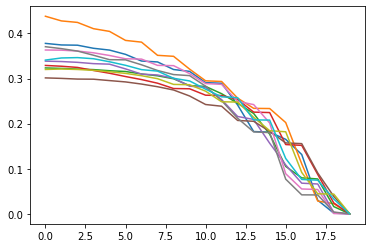

In [62]:
for h in range(10):
    plot(dataS[1][h])


In [14]:
def sortDataFullIntoSets(data,width):
    bins=[]
    for w in range(width+1):
        bins.append([])
    for i in range(2**width):
        bins[bin(i).count('1')].append(data[i])
    return bins

def sortDataFullIntoDictSets(data,width):
    bins=[]
    for w in range(width+1):
        bins.append(dict())
    for i in range(2**width):
        bins[bin(i).count('1')][i]=data[i]
    return bins


In [ ]:
def removalIntoVec(res,width,H):
    V=numpy.zeros(width)
    for i,r in enumerate(res):
        for e in r:
            V[e]+=H[0]-H[i]
    return V
    #V=sqrt(V)\    print(V)
    if V.sum()==0:
        return V
    return V/V.max()

def removalIntoMatrix(res,width,H):
    M=[]
    for i in range(10):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

def smearedness(M):
    S=[]
    for i in range(20):
        S.append(sort(M.transpose()[i])[:-1].sum())
    return numpy.array(S)

#imshow(removalIntoMatrix(dataS[0],20,dataS[1]))
M=removalIntoMatrix(S,20,H)
imshow(removalIntoMatrix(S,20,H))
print("smearedness",smearedness(M))

In [12]:
fn="composedModel"
dataS,dataKO,dataI,dataR=aggregateData("{0}.model".format(fn))


In [16]:
def nodeListToID(nodeList):
    i=0
    for node in nodeList:
        i+=(1<<node)
    return i

def shrinkingDecompositionInformationBranchPrecomputedData(dataI,width,numbers=[0,1,2,3,4,5,6,7,8,9]):
    for number in numbers:
        bestSets=[]
        bestI=[]
        currentSets=[list(range(width))]
        for step in range(width):
            possibleSubsets=[]
            for subset in currentSets:
                for node in subset:
                    nextsubset=copy.deepcopy(subset)
                    nextsubset.remove(node)
                    if nextsubset not in possibleSubsets:
                        possibleSubsets.append(nextsubset)
            values=[]
            for s in possibleSubsets:
                values.append(dataI[number][nodeListToID(s)])
            maxValue=max(values)
            bestI.append(maxValue)
            currentSets=[]
            for i,s in enumerate(possibleSubsets):
                if values[i]>=maxValue:
                    currentSets.append(s)
            bestSets.append(copy.deepcopy(currentSets))
    return bestSets,bestI

shrinkingDecompositionInformationBranchPrecomputedData(dataI,20,numbers=[9])

([[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]],
  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19]],
  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 17, 18, 19]],
  [[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 15, 17, 18, 19]],
  [[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 17, 18, 19]],
  [[0, 1, 2, 3, 4, 5, 6, 7, 10, 12, 13, 17, 18, 19]],
  [[0, 1, 2, 3, 4, 5, 6, 10, 12, 13, 17, 18, 19]],
  [[0, 1, 2, 3, 4, 5, 10, 12, 13, 17, 18, 19]],
  [[0, 1, 2, 3, 4, 10, 12, 13, 17, 18, 19]],
  [[0, 1, 2, 3, 10, 12, 13, 17, 18, 19]],
  [[0, 1, 2, 3, 10, 12, 13, 18, 19]],
  [[0, 1, 2, 10, 12, 13, 18, 19]],
  [[0, 1, 10, 12, 13, 18, 19]],
  [[0, 1, 10, 12, 18, 19]],
  [[0, 1, 10, 18, 19]],
  [[0, 1, 18, 19]],
  [[0, 18, 19]],
  [[18, 19]],
  [[19]],
  [[]]],
 [0.3454308030733291,
  0.34887596571694424,
  0.3495679846195161,
  0.3449780733741701,
  0.3399055745197819,
  0.33397745017102487,
  0.32309580140804517,
  0.31813751565003034,
  0.3004983804596675,
  0.

0 0.0005636215209960938 [10, 12] [[[6, 7, 10, 12]], [[6, 10, 12]], [[10, 12]]]
1 0.0014858245849609375 [0, 8] [[[8, 16, 17, 18]], [[8, 17, 18]], [[8, 18]]]
2 0.0005016326904296875 [5, 18] [[[5, 8, 18, 19]], [[5, 18, 19]], [[5, 18]]]
3 0.0004949569702148438 [9, 17] [[[0, 5, 9, 17]], [[0, 9, 17]], [[9, 17]]]
4 0.000640869140625 [16, 17] [[[7, 9, 16, 17]], [[7, 16, 17]], [[16, 17]]]
5 0.00049591064453125 [6, 9] [[[6, 7, 9, 17]], [[6, 7, 9]], [[6, 9]]]
6 0.000423431396484375 [7, 15] [[[7, 15, 18, 19]], [[7, 15, 18]], [[7, 15]]]
7 0.0005397796630859375 [17, 19] [[[15, 16, 17, 19]], [[15, 17, 19]], [[17, 19]]]
8 0.0023393630981445312 [4, 9] [[[4, 6, 9, 19]], [[4, 6, 9]], [[6, 9]]]
9 0.0005998611450195312 [16, 17] [[[0, 9, 16, 17]], [[0, 16, 17]], [[16, 17]]]


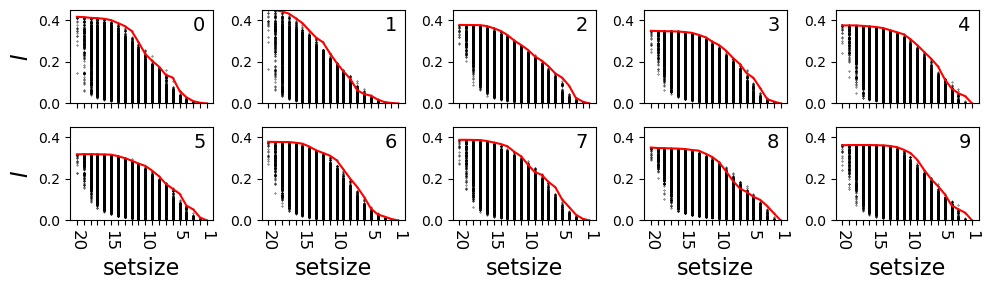

In [52]:
#fn="composedModel"
fn="fullModel"
dataS,dataKO,dataI,dataR=aggregateData("{0}.model".format(fn))
figure(figsize=[10,3])
for i in range(10):
    subplot(2,5,i+1)
    bins=sortDataFullIntoSets(dataI[i],20)
    for j in range(20):
        plot([20-j]*len(bins[j]),bins[j],'.k',markersize=0.6,rasterized=True)
    if i in [0,5]:
        ylabel(r"$I$",fontsize=16)
    if i in [5,6,7,8,9]:
        xlabel("setsize",fontsize=16)
        xticks(range(1,21),['20','','','','','15','','','','','10','','','','','5','','','','1'],fontsize=12,rotation=-90)
    else:
        xticks(range(21),['']*21)
    text(18,0.35,str(i),fontsize=14)
    ylim(0,0.45)
    x,y=shrinkingDecompositionInformationBranchPrecomputedData(dataI,20,numbers=[i])
    plot(range(1,21),y,'r')

    #plot(range(1,21),dataS[1][i],'r')
    total=0
    for j in range(20):
        total+=(1.0*(numpy.array(bins[20-j])>y[j])).sum()
        #total+=(1.0*(numpy.array(bins[20-j])>dataS[1][i][j])).sum()
        #print(i,'above',(1.0*(numpy.array(bins[20-j])>dataS[1][i][j])).sum())
    print(i,total/2**20,dataS[0][i][-3],x[-5:-2])
    
tight_layout()
savefig("setAnalysis{0}.pdf".format(fn))
#figure(figsize=[10,3])    
#for i in range(10):
#    subplot(2,5,i+1)
#    bins=sortDataFullIntoSets(dataR[i],20)
#    for j in range(20):
#        plot([20-j]*len(bins[j]),bins[j],'.k')
#    plot(range(1,21),dataS[1][i],'r')

#figure()
#Mcomp=removalIntoMatrix(dataS[0],20,dataS[1])
#imshow(Mcomp)

In [ ]:
fn="composedModel"
dataS,dataKO,dataI,dataR=aggregateData("{0}.model".format(fn))


13
11
3
2
1
4
15
12
16
17
14
6
7
10
0
9
8
19
18
5


<Figure size 640x480 with 0 Axes>

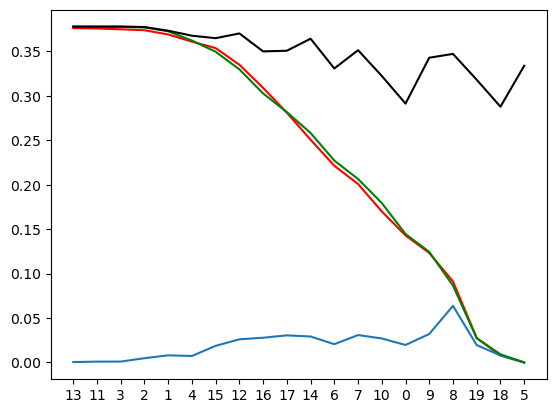

<Figure size 640x480 with 0 Axes>

In [24]:
setID=2
Y=dataS[1][setID]
D=[]
sets=[set(range(20))]
for i in range(20):
    sets.append(set(dataS[0][setID][i]))
Xl=[]
for i in range(20):
    #print(sets[i]-sets[i+1])
    Xl.append(list(sets[i]-sets[i+1])[0])
    D.append(Y[i]-(Y+[0])[i+1])
plot(Y,'r')
xticks(range(20),Xl)    
plot(D)
print()
x,y=shrinkingDecompositionInformationBranchPrecomputedData(dataI,20,numbers=[setID])
plot(y,'g')
L=[]
for node in Xl:
    fullSet=list(range(20))
    fullSet.remove(node)
    L.append(dataI[setID][nodeListToID(fullSet)])
    print(node)
plot(L,'k')
figure()


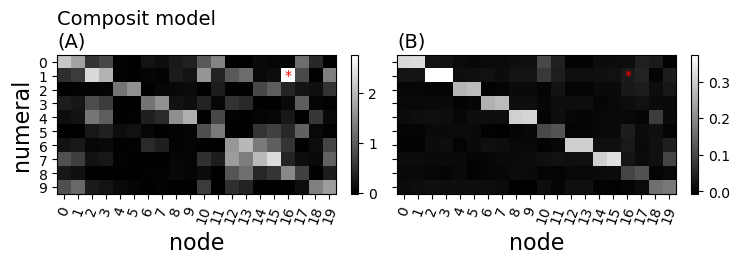

In [21]:
figure(figsize=[7.5,3])
subplot(1,2,1)
imshow(removalIntoMatrix(dataS[0],20,dataS[1]),cmap="gray")
yticks(range(10),fontsize=10)
xticks(range(20),fontsize=10,rotation=70)
xlabel("node",fontsize=16)
ylabel("numeral",fontsize=16)
title("Composit model\n(A)",fontsize=14,loc="left")
text(15.8,1.3,"*",color="r")
colorbar(fraction=0.023)
M=numpy.zeros((10,20))

for i in range(10):
    x,y=shrinkingDecompositionInformationBranchPrecomputedData(dataI,20,numbers=[i])
    L=[]
    for j,node in enumerate(Xl):
        fullSet=list(range(20))
        #fullSet.remove(node)
        fullSet.remove(j)
        #M[i][node]=(1.0-dataI[i][0])-dataI[i][nodeListToID(fullSet)]
        M[i][j]=dataI[i][nodeListToID(list(range(20)))]-dataI[i][nodeListToID(fullSet)]
        #if(i==0):
        #    print(node,fullSet)
ylim(9.5,-0.5)
subplot(1,2,2)
imshow(M,cmap="gray")
yticks(range(10),[""]*10,fontsize=10)
xticks(range(20),fontsize=10,rotation=70)
xlabel("node",fontsize=16)
title("(B)",fontsize=14,loc="left")
text(15.8,1.3,"*",color="r")
colorbar(fraction=0.023)
ylim(9.5,-0.5)
tight_layout()
savefig("nodeResultComposed.pdf")

In [22]:
fn="fullModel"
dataS,dataKO,dataI,dataR=aggregateData("{0}.model".format(fn))

In [ ]:
setID=2
Y=dataS[1][setID]
D=[]
sets=[set(range(20))]
for i in range(20):
    sets.append(set(dataS[0][setID][i]))
Xl=[]
for i in range(20):
    #print(sets[i]-sets[i+1])
    Xl.append(list(sets[i]-sets[i+1])[0])
    D.append(Y[i]-(Y+[0])[i+1])
plot(Y,'r')
xticks(range(20),Xl)    
plot(D)
print()
x,y=shrinkingDecompositionInformationBranchPrecomputedData(dataI,20,numbers=[setID])
plot(y,'g')
L=[]
for node in Xl:
    fullSet=list(range(20))
    fullSet.remove(node)
    L.append(dataI[setID][nodeListToID(fullSet)])
    print(node)
plot(L,'k')
figure()


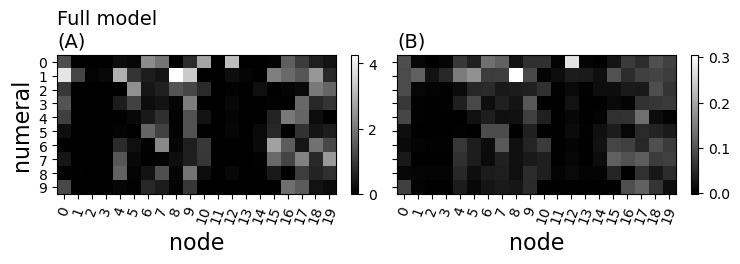

In [26]:
figure(figsize=[7.5,3])
subplot(1,2,1)
imshow(removalIntoMatrix(dataS[0],20,dataS[1]),cmap="gray")
yticks(range(10),fontsize=10)
xticks(range(20),fontsize=10,rotation=70)
xlabel("node",fontsize=16)
ylabel("numeral",fontsize=16)
title("Full model\n(A)",fontsize=14,loc="left")
M=numpy.zeros((10,20))
for i in range(10):
    x,y=shrinkingDecompositionInformationBranchPrecomputedData(dataI,20,numbers=[i])
    L=[]
    for j,node in enumerate(Xl):
        fullSet=list(range(20))
        #fullSet.remove(node)
        fullSet.remove(j)
        #M[i][node]=(1.0-dataI[i][0])-dataI[i][nodeListToID(fullSet)]
        M[i][j]=dataI[i][nodeListToID(list(range(20)))]-dataI[i][nodeListToID(fullSet)]
colorbar(fraction=0.023)
ylim(9.5,-0.5)

subplot(1,2,2)
imshow(M,cmap="gray")
yticks(range(10),[""]*10,fontsize=10)
xticks(range(20),fontsize=10,rotation=70)
xlabel("node",fontsize=16)
title("(B)",fontsize=14,loc="left")
#text(8.05,1,"*",color="r")
#text(12.05,,"*",color="r")
colorbar(fraction=0.023)
ylim(9.5,-0.5)
tight_layout()
savefig("nodeResultFull.pdf")

In [ ]:
#testing a couple of functions

In [3]:
N=1000
x=linspace(0,1,N)
r=numpy.random.normal(0,0.1,(N))
data = DataFrame({'A': x+r, 'B': x, 'E':x,'C': r, 'R1':numpy.random.normal(0,0.1,(N)),'R2':numpy.random.normal(0,0.1,(N))})

model = ols("A ~ B + C", data).fit()
#print("name:",name)
#print(model.summary())
#print("\nRetrieving manually the parameter estimates:")
params=model._results.params
anova_results = anova_lm(model)#typ=2)
#print(i,params)
#print(anova_results)
#high F means explained, low F means not explained
print(model._results.summary())

NameError: name 'linspace' is not defined

In [4]:
#this needs to be run firstm the next cells add data to this collector for plotting it later
collector=dict()

                 df         sum_sq        mean_sq             F  PR(>F)
D               1.0   12534.319878   12534.319878  5.237195e+05     0.0
I               1.0  151293.048850  151293.048850  6.321453e+06     0.0
Residual  1048573.0   25095.780026       0.023933           NaN     NaN
                            OLS Regression Results                            
Dep. Variable:                      K   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                 3.423e+06
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        08:57:17   Log-Likelihood:             4.6903e+05
No. Observations:             1048576   AIC:                        -9.381e+05
Df Residuals:                 1048573   BIC:                        -9.380e+05
Df Model:                           2                                         
C

                 df         sum_sq        mean_sq             F  PR(>F)
D               1.0   12389.020854   12389.020854  8.185898e+05     0.0
I               1.0  156775.755230  156775.755230  1.035877e+07     0.0
Residual  1048573.0   15869.722379       0.015135           NaN     NaN
                            OLS Regression Results                            
Dep. Variable:                      K   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 5.589e+06
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        08:57:18   Log-Likelihood:             7.0931e+05
No. Observations:             1048576   AIC:                        -1.419e+06
Df Residuals:                 1048573   BIC:                        -1.419e+06
Df Model:                           2                                         
C

                 df        sum_sq       mean_sq             F  PR(>F)
D               1.0  12057.089189  12057.089189  3.600604e+05     0.0
I               1.0  88430.524019  88430.524019  2.640797e+06     0.0
Residual  1048573.0  35112.830022      0.033486           NaN     NaN
                            OLS Regression Results                            
Dep. Variable:                      K   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                 1.500e+06
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        08:57:20   Log-Likelihood:             2.9294e+05
No. Observations:             1048576   AIC:                        -5.859e+05
Df Residuals:                 1048573   BIC:                        -5.858e+05
Df Model:                           2                                         
Covarianc

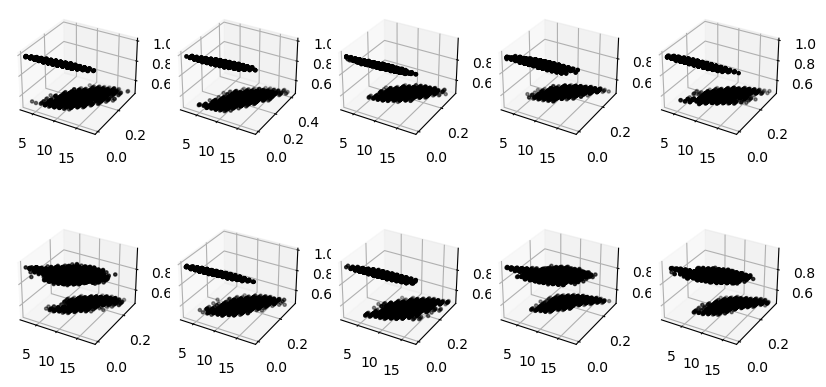

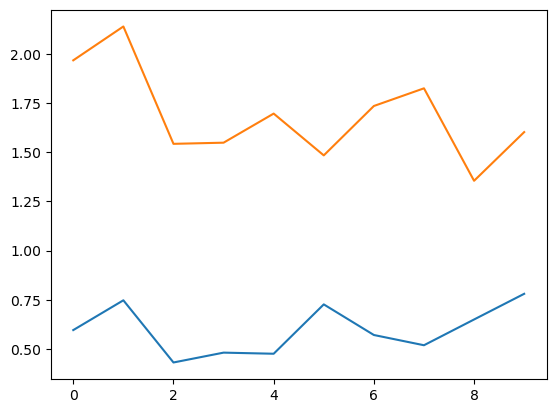

In [28]:
def normD(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

dataS,dataKO,dataI,dataR=aggregateData("composedModel.model")
dataDepth=numpy.zeros((2**20))
for i in range(2**20):
    dataDepth[i]=bin(i).count('1')
    
fig=figure(figsize=[10,5])
D=[]
I=[]
Dt=[]
It=[]
CC_KO=[]
CC_I=[]
F=[]
P=[]
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,projection='3d')#,elev=0.0, azim=-90.0*u)
    subSample=numpy.random.choice(range(2**20),(10000))
    ax.scatter(dataDepth[subSample],dataI[i][subSample],dataKO[i][subSample],marker='.',color='k')
    
    data = DataFrame({'D': normD(dataDepth), 'K': normD(dataKO[i]), 'I': normD(dataI[i]), 'R':numpy.random.random((2**20))})
    model = ols("K ~  D + I", data).fit()
    pearCoefKO,pValueKO=stats.pearsonr(normD(dataKO[i]),normD(dataDepth))
    pearCoefI,pValueI=stats.pearsonr(normD(dataI[i]),normD(dataDepth))
    CC_KO.append(pearCoefKO)
    CC_I.append(pearCoefI)
    #print("name:",name)
    #print(model.summary())
    #print("\nRetrieving manually the parameter estimates:")
    params=model._results.params
    anova_results = anova_lm(model)
    F.append(model.fvalue)
    #print(i,params)
    print(anova_results)
    print(model._results.summary())
    D.append(model.params.D)
    I.append(model.params.I)
    Dt.append(model._results.tvalues[1])
    It.append(model._results.tvalues[2])
figure()
plot(D)
plot(numpy.abs(I))
collector["composed"]=[D,I,Dt,It,CC_KO,CC_I,F]
print(F)
print(min(F))

                 df        sum_sq       mean_sq              F  PR(>F)
D               1.0   2991.116388   2991.116388  132233.882545     0.0
I               1.0  18655.243803  18655.243803  824727.291664     0.0
Residual  1048573.0  23718.609968      0.022620            NaN     NaN
                            OLS Regression Results                            
Dep. Variable:                      K   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                 4.785e+05
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        08:57:30   Log-Likelihood:             4.9862e+05
No. Observations:             1048576   AIC:                        -9.972e+05
Df Residuals:                 1048573   BIC:                        -9.972e+05
Df Model:                           2                                         
Covar

                 df        sum_sq       mean_sq             F  PR(>F)
D               1.0   5531.390709   5531.390709  2.313271e+05     0.0
I               1.0  37817.711163  37817.711163  1.581566e+06     0.0
Residual  1048573.0  25073.015154      0.023912           NaN     NaN
                            OLS Regression Results                            
Dep. Variable:                      K   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                 9.064e+05
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        08:57:31   Log-Likelihood:             4.6951e+05
No. Observations:             1048576   AIC:                        -9.390e+05
Df Residuals:                 1048573   BIC:                        -9.390e+05
Df Model:                           2                                         
Covarianc

                 df        sum_sq       mean_sq             F  PR(>F)
D               1.0   6507.725542   6507.725542  2.259092e+05     0.0
I               1.0  30066.022643  30066.022643  1.043712e+06     0.0
Residual  1048573.0  30206.050626      0.028807           NaN     NaN
                            OLS Regression Results                            
Dep. Variable:                      K   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                 6.348e+05
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        08:57:33   Log-Likelihood:             3.7186e+05
No. Observations:             1048576   AIC:                        -7.437e+05
Df Residuals:                 1048573   BIC:                        -7.437e+05
Df Model:                           2                                         
Covarianc

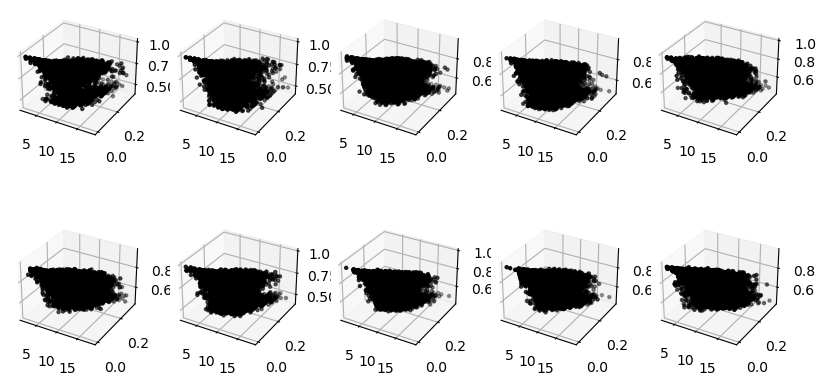

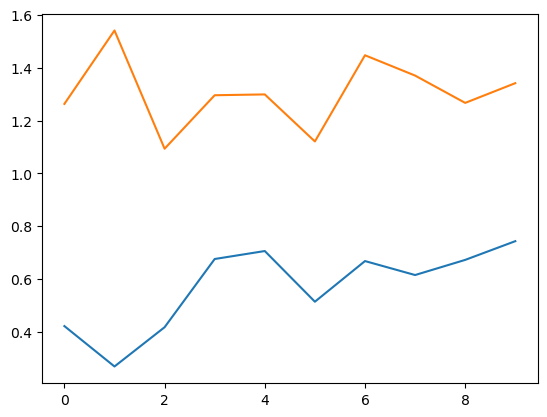

In [29]:
def normD(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

dataS,dataKO,dataI,dataR=aggregateData("fullModel.model")
#dataS,dataKO,dataI,dataR=aggregateData("composedModel.model")
dataDepth=numpy.zeros((2**20))
for i in range(2**20):
    dataDepth[i]=bin(i).count('1')
    
fig=figure(figsize=[10,5])
D=[]
I=[]
Dt=[]
It=[]
F=[]
P=[]
CC_KO=[]
CC_I=[]
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,projection='3d')#,elev=0.0, azim=-90.0*u)
    subSample=numpy.random.choice(range(2**20),(10000))
    ax.scatter(dataDepth[subSample],dataI[i][subSample],dataKO[i][subSample],marker='.',color='k')
    
    data = DataFrame({'D': normD(dataDepth), 'K': normD(dataKO[i]), 'I': normD(dataI[i]), 'R':numpy.random.random((2**20))})
    pearCoefKO,pValueKO=stats.pearsonr(normD(dataKO[i]),normD(dataDepth))
    pearCoefI,pValueI=stats.pearsonr(normD(dataI[i]),normD(dataDepth))
    CC_KO.append(pearCoefKO)
    CC_I.append(pearCoefI)

    model = ols("K ~  D + I", data).fit()
    #print("name:",name)
    #print(model.summary())
    #print("\nRetrieving manually the parameter estimates:")
    params=model._results.params
    F.append(model.fvalue)
    #P.append(anova_results.p)
    anova_results = anova_lm(model)
    #print(i,params)
    print(anova_results)
    print(model._results.summary())
    D.append(model.params.D)
    I.append(model.params.I)
    Dt.append(model._results.tvalues[1])
    It.append(model._results.tvalues[2])
figure()
plot(D)
plot(numpy.abs(I))
#collector["composed"]=[D,I,Dt,It]
collector["full"]=[D,I,Dt,It,CC_KO,CC_I,F]
print(F)
print(min(F))

147.7160745002004
800.6042592126455
336.5716658168788
1625.0529544508934


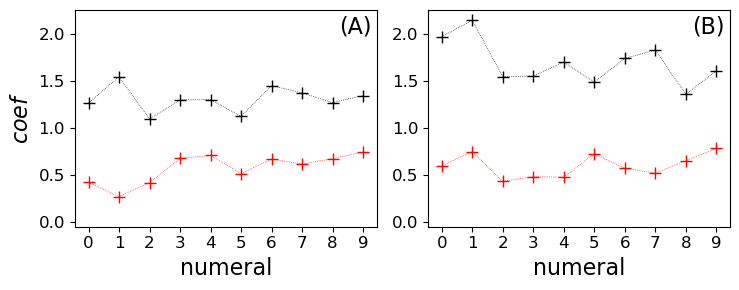

In [32]:
figure(figsize=[7.5,3])
subplot(1,2,1)
plot(collector["full"][0],"+r",markersize=8.0)
plot(collector["full"][0],":r",linewidth=0.5)
plot(numpy.abs(collector["full"][1]),"+k",markersize=8.0)
plot(numpy.abs(collector["full"][1]),":k",linewidth=0.5)
ylim(-0.05,2.25)
xlabel("numeral",fontsize=16)
xticks(range(10),fontsize=12)
ylabel(r"$coef$",fontsize=16)
yticks(fontsize=12)
text(8.2,2.0,"(A)",fontsize=16)
#twinx()
#plot(numpy.abs(collector["full"][2]))
#plot(numpy.abs(collector["full"][3]))

print(numpy.abs(collector["full"][2]).min())
print(numpy.abs(collector["full"][3]).min())
subplot(1,2,2)
plot(collector["composed"][0],"+r",markersize=8.0)
plot(collector["composed"][0],":r",linewidth=0.5)
plot(numpy.abs(collector["composed"][1]),"+k",markersize=8.0)
plot(numpy.abs(collector["composed"][1]),":k",linewidth=0.5)
ylim(-0.05,2.25)
xlabel("numeral",fontsize=16)
xticks(range(10),fontsize=12)
yticks(fontsize=12)
text(8.2,2.0,"(B)",fontsize=16)
#twinx()
#plot(numpy.abs(collector["full"][2]))
#plot(numpy.abs(collector["full"][3]))

print(numpy.abs(collector["composed"][2]).min())
print(numpy.abs(collector["composed"][3]).min())
tight_layout()
savefig("multipleRegression.pdf")

336.5716658168788
1625.0529544508934


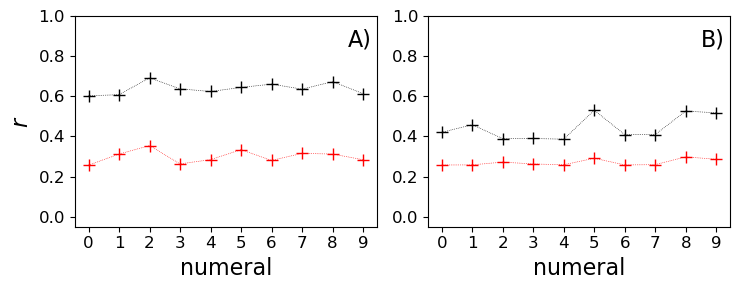

In [56]:
#older figure plotting r - which is not the right thing to do ... but kept for completeness 
figure(figsize=[7.5,3])
subplot(1,2,1)
plot(numpy.abs(collector["full"][4]),"+r",markersize=8.0)
plot(numpy.abs(collector["full"][4]),":r",linewidth=0.5)
plot(numpy.abs(collector["full"][5]),"+k",markersize=8.0)
plot(numpy.abs(collector["full"][5]),":k",linewidth=0.5)
ylim(-0.05,1.0)
xlabel("numeral",fontsize=16)
xticks(range(10),fontsize=12)
ylabel(r"$r$",fontsize=16)
yticks(fontsize=12)
text(8.5,0.85,"A)",fontsize=16)
#twinx()
#plot(numpy.abs(collector["full"][2]))
#plot(numpy.abs(collector["full"][3]))

#print(numpy.abs(collector["full"][2]).min())
#print(numpy.abs(collector["full"][3]).min())
subplot(1,2,2)
plot(numpy.abs(collector["composed"][4]),"+r",markersize=8.0)
plot(numpy.abs(collector["composed"][4]),":r",linewidth=0.5)
plot(numpy.abs(collector["composed"][5]),"+k",markersize=8.0)
plot(numpy.abs(collector["composed"][5]),":k",linewidth=0.5)
ylim(-0.05,1.0)
xlabel("numeral",fontsize=16)
xticks(range(10),fontsize=12)
yticks(fontsize=12)
text(8.5,0.85,"B)",fontsize=16)
#twinx()
#plot(numpy.abs(collector["full"][2]))
#plot(numpy.abs(collector["full"][3]))

print(numpy.abs(collector["composed"][2]).min())
print(numpy.abs(collector["composed"][3]).min())
tight_layout()
savefig("multipleRegression.pdf")

In [14]:
def symbolEntropy(D,base=2):
    value,counts = numpy.unique(D, return_counts=True)
    return entropy(counts,base=base)

def sharedABC(A,B,C,nrOfBits=4):
    nrOfBins=2**nrOfBits
    A=numpy.digitize(A,numpy.linspace(A.min(),A.max(),nrOfBins))-1
    B=numpy.digitize(B,numpy.linspace(B.min(),B.max(),nrOfBins))-1
    C=numpy.digitize(C,numpy.linspace(C.min(),C.max(),nrOfBins))-1
    for i in range(nrOfBins):
        for who in [A,B,C]:
            if i not in unique(who):
                who=numpy.array(list(who).append(i))
    AB=(A*nrOfBins)+B
    AC=(A*nrOfBins)+C
    BC=(B*nrOfBins)+C
    ABC=((A*nrOfBins)*nrOfBins)+(B*nrOfBins)+C    
    Ha=symbolEntropy(A,2.0)
    Hb=symbolEntropy(B,2.0)
    Hc=symbolEntropy(C,2.0)
    Hab=symbolEntropy(AB,2.0)
    Hac=symbolEntropy(AC,2.0)
    Hbc=symbolEntropy(BC,2.0)
    Habc=symbolEntropy(ABC,2.0)
    return Ha+Hb+Hc-Hab-Hac-Hbc+Habc

def sharedABGivenC(A,B,C,nrOfBits=4):
    nrOfBins=2**nrOfBits
    A=numpy.digitize(A,numpy.linspace(A.min(),A.max(),nrOfBins))-1
    B=numpy.digitize(B,numpy.linspace(B.min(),B.max(),nrOfBins))-1
    C=numpy.digitize(C,numpy.linspace(C.min(),C.max(),nrOfBins))-1
    AC=(A*nrOfBins)+C
    BC=(B*nrOfBins)+C
    ABC=((A*nrOfBins)*nrOfBins)+(B*nrOfBins)+C
    Hc=symbolEntropy(C,2.0)
    Hac=symbolEntropy(AC,2.0)
    Hbc=symbolEntropy(BC,2.0)
    Habc=symbolEntropy(ABC,2.0)
    return -Hc+Hac+Hbc-Habc


for i in range(10):
    A=dataKO[i]
    B=dataI[i]
    C=dataDepth
    nob=5
    s=sharedABC(A,B,C,nob)
    g=sharedABGivenC(A,B,C,nob)
    print(g,s)

NameError: name 'dataDepth' is not defined

In [143]:
from sklearn import linear_model
for ms in ["full","composed"]:
    dataS,dataKO,dataI,dataR=aggregateData("{0}Model.model".format(ms))
    for i in range(10):
        data = DataFrame({'D': normD(dataDepth), 'K': normD(dataKO[i]), 'I': normD(dataI[i]), 'R':numpy.random.random((2**20))})
        X = data[['I','D']]
        y = data['K']

        regr = linear_model.LinearRegression()
        regr.fit(X, y)
        print(regr.coef_)
        
#tau kendalls tau test

[-1.26314467  0.42208551]
[-1.54106466  0.26919768]
[-1.09352293  0.41779954]
[-1.295946    0.67602219]
[-1.29901963  0.70621436]
[-1.1209621   0.51436693]
[-1.44727344  0.66822904]
[-1.37036234  0.6153225 ]
[-1.26693286  0.67268013]
[-1.34164557  0.74354229]
[-1.96804385  0.5960346 ]
[-2.1401559   0.74748694]
[-1.54325971  0.43124153]
[-1.54912027  0.48130642]
[-1.69709535  0.47568809]
[-1.48453713  0.7266932 ]
[-1.7357403   0.57099602]
[-1.8256011   0.51890478]
[-1.35532228  0.64990352]
[-1.60299155  0.78049769]


In [138]:
def koDecomposition(dataKO,numbers=list(range(10))):
    Hs=dict()
    Ss=dict()
    for number in numbers:
        nodeSet=list(range(20))
        H=[]
        setSequence=[]
        while(len(nodeSet)>1):
            hs=[]
            subSets=[]
            for node in nodeSet:
                subSet=copy.deepcopy(nodeSet)
                subSet.remove(node)
                mask=(2**20)-1
                for s in subSet:
                    mask-=1*(2**s)
                mask=int(mask)
                #print(bin(mask))
                subSets.append(subSet)
                hs.append(dataKO[number][mask])
            best=hs.index(min(hs))
            setSequence.append(subSets[best])
            H.append(hs[best])
            nodeSet=subSets[best]
        Hs[number]=H
        Ss[number]=setSequence
    return Ss,Hs
S,H=koDecomposition(dataKO)

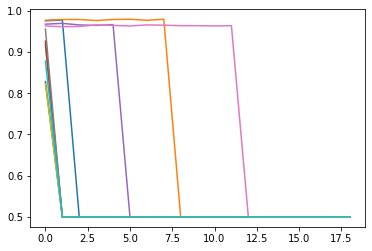

In [139]:
for i in range(10):
    plot(H[i])

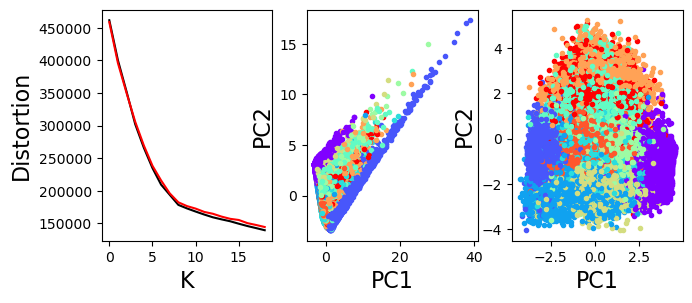

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

for image,target in train_full:
    pass
pcas=[]
figure(figsize=[7.5,3])
cols=["k","r"]
subplot(1,3,1)
Is=[]
for w,who in enumerate(["full","composed"]):
    model.load_state_dict(torch.load("paper/{0}Model.model".format(who)))
    out=model(image)
    I=[]
    for i in range(2,21):
        kmeans=KMeans(n_clusters=i).fit(model.hidden[0])
        I.append(kmeans.inertia_)
    Is.append(I)
    plot(I,color=cols[w])
    X = StandardScaler().fit_transform(model.hidden[0])
    pca = PCA(2)
    X_pca = pca.fit_transform(X)
    pcas.append(X_pca)
ylabel("Distortion",fontsize=16)
xlabel("K",fontsize=16)
cmap = matplotlib.cm.get_cmap('rainbow')
for j in range(2):
    subplot(1,3,2+j)
    for i in range(60000):
        plot(pcas[j].transpose()[0][i],pcas[j].transpose()[1][i],'.',color=cmap(linspace(0,1,10)[target[i]]))
    xlabel("PC1",fontsize=16)
    ylabel("PC2",fontsize=16)

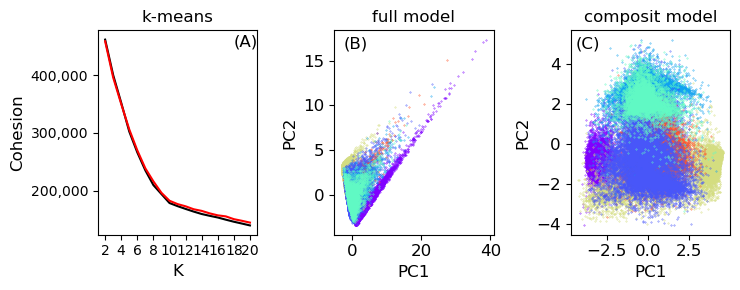

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import colors
figure(figsize=[7.5,3])
cols=["k","r"]
subplot(1,3,1)
for w,who in enumerate(["full","composed"]):
    plot(range(2,21),Is[w],color=cols[w])
title("k-means")
ylabel("Cohesion",fontsize=12)
xlabel("K",fontsize=12)
xticks(range(2,21,2),fontsize=10)
yticks([200000,300000,400000],['200,000','300,000','400,000'],fontsize=10)
text(18,450000,"(A)", fontsize=12)
cmap = matplotlib.cm.get_cmap('rainbow')
for j,who in enumerate(["full","composed"]):
    subplot(1,3,2+j)
    for i in range(10):
        ids=numpy.where(target==i)
        c=cmap(linspace(0,1,10)[target[i]])
        plot(pcas[j].transpose()[0][ids],pcas[j].transpose()[1][ids],'o',color=c,markersize=0.3)
   
    xlabel("PC1",fontsize=12)
    ylabel("PC2",fontsize=12)
    if j==1:
        title("composit model")
    else:
        title(who+" model")
    xticks(fontsize=12)
    yticks(fontsize=12)
    if j==0:
        text(-2.5,16.4,"(B)", fontsize=12)
    else:
        text(-4.4,4.8,"(C)", fontsize=12)

tight_layout()
savefig("space.pdf")

In [ ]:
#the following plots are not show, but show the distribution of hidden state values for each node, 
#on can see that they are fairly binary

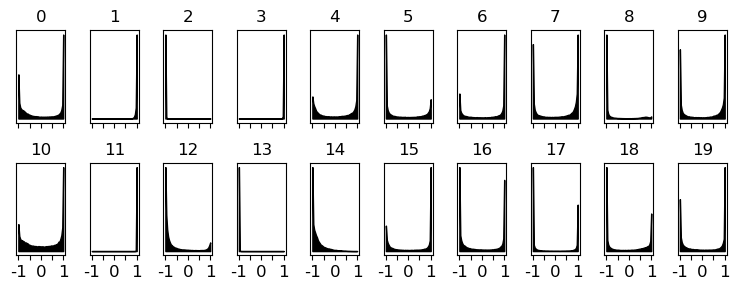

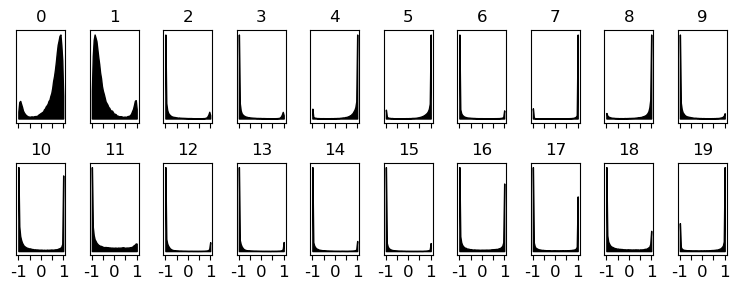

In [40]:
for who in ["full","composed"]:
    model.load_state_dict(torch.load("paper/{0}Model.model".format(who)))
    out=model(image)
    figure(figsize=[7.5,3])
    for i in range(20):
        subplot(2,10,i+1)
        H=histogram(model.hidden[0].transpose()[i],linspace(-1,1,51))
        fill_between(linspace(-1.0,1.0,50),numpy.zeros((50)),H[0].flatten(),color='k')
        yticks([],[])
        if i<10:
            xticks([-1,-0.5,0,0.5,1],["","","","",""])
        else:
            xticks([-1,-0.5,0,0.5,1],["-1","","0","","1"],fontsize=12)
        title(str(i))
    tight_layout()
    savefig("state_hist_{0}.pdf".format(who))

In [ ]:
#computing entropies for the supplementary information

In [47]:
for who in ["full","composed"]:
    model.load_state_dict(torch.load("paper/{0}Model.model".format(who)))
    out=model(image)

    A,B,C=getOutTaH(model,train_full)
    print(who,symbolEntropy(B))

full 3.3198709267551885
composed 3.3198709267551885


In [48]:
#yes, I can't do this by hand - lol
log(10)/log(2)

3.3219280948873626

In [46]:
Hs=[]
for i in range(1000):
    Hs.append(symbolEntropy(numpy.random.randint(0,2**20,(60000))))

print(mean(Hs),std(Hs),var(Hs))

15.816153114338345 0.0013853541841516565 1.919206215546502e-06
